In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

/opt/anaconda3/envs/hebbian/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploration

### Load trained models

In [53]:
from genhebb import GenHebb, hebbs_rule, random_W

In [54]:
hebbs_rule1 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule5 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule10 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule50 = GenHebb(28*28, 2000, 10, hebbs_rule)
random_W = GenHebb(28*28, 2000, 10, random_W)
baseline = Baseline(28*28, 2000, 10)

In [55]:
hebbs_rule1.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule5.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-5_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule10.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-10_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule50.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-50_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
random_W.load_state_dict(torch.load('saved_models/genhebb-random_W-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
baseline.load_state_dict(torch.load('saved_models/baseline-50_epochs-0.001_lr-64_batch.pt'))

<All keys matched successfully>

### Investigate unsup layer weight matrix

In [56]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=2)

In [58]:
trainset = FastMNIST('./data', train=True, download=True)

In [59]:
images, labels = next(iter(DataLoader(trainset, batch_size=5000, shuffle=True)))

In [60]:
x = images.reshape(-1, 28*28)
x_proj = pca.fit_transform(x)

In [49]:
Wx_hebbs_rule1 = hebbs_rule1.unsup_layer(x)
Wx_proj_hebbs_rule1 = pca.fit_transform(Wx_hebbs_rule1.detach())
Wx_hebbs_rule5 = hebbs_rule5.unsup_layer(x)
Wx_proj_hebbs_rule5 = pca.fit_transform(Wx_hebbs_rule5.detach())
Wx_hebbs_rule10 = hebbs_rule10.unsup_layer(x)
Wx_proj_hebbs_rule10 = pca.fit_transform(Wx_hebbs_rule10.detach())
Wx_hebbs_rule50 = hebbs_rule50.unsup_layer(x)
Wx_proj_hebbs_rule50 = pca.fit_transform(Wx_hebbs_rule50.detach())
Wx_random_W = random_W.unsup_layer(x)
Wx_proj_random_W = pca.fit_transform(Wx_random_W.detach())

In [62]:
Wx_baseline = baseline.input(x)
Wx_proj_baseline = pca.fit_transform(Wx_baseline.detach())

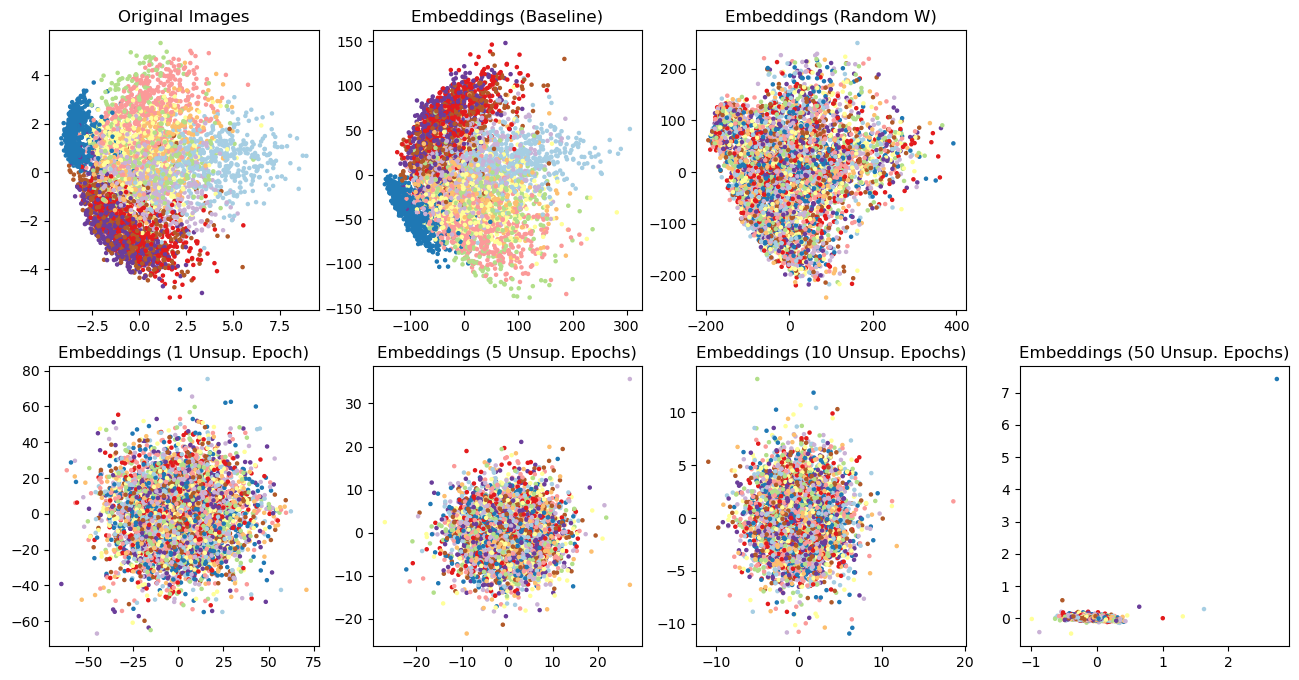

In [67]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].scatter(x_proj[:, 0], x_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 1].scatter(Wx_proj_baseline[:, 0], Wx_proj_baseline[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 2].scatter(Wx_proj_random_W[:, 0], Wx_proj_random_W[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 0].scatter(Wx_proj_hebbs_rule1[:, 0], Wx_proj_hebbs_rule1[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 1].scatter(Wx_proj_hebbs_rule5[:, 0], Wx_proj_hebbs_rule5[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 2].scatter(Wx_proj_hebbs_rule10[:, 0], Wx_proj_hebbs_rule10[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 3].scatter(Wx_proj_hebbs_rule50[:, 0], Wx_proj_hebbs_rule50[:, 1], c=labels, cmap='Paired', s=5)

axes[0, 0].set_title('Original Images')
axes[0, 1].set_title('Embeddings (Baseline)')
axes[0, 2].set_title('Embeddings (Random W)')
axes[0, 3].axis('off')
axes[1, 0].set_title('Embeddings (1 Unsup. Epoch)')
axes[1, 1].set_title('Embeddings (5 Unsup. Epochs)')
axes[1, 2].set_title('Embeddings (10 Unsup. Epochs)')
axes[1, 3].set_title('Embeddings (50 Unsup. Epochs)')
fig.savefig('figures/embeddings_comparison.png', dpi=300)